In [1]:
import sys
sys.path.append('../')

import numpy as np
import core

%load_ext autoreload
%autoreload 2

from core.pwe import PlaneWaveExp
import matplotlib.pyplot as plt

## Reproduce Fig. 10 in Chapter 5 of "Photonic Crystals: Molding the Flow of Light"

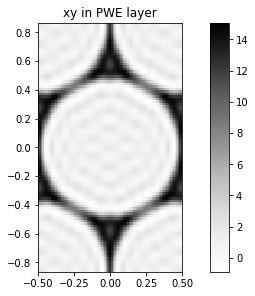

In [2]:
# Initialize a lattice
lattice = core.Lattice('hexagonal')
# Initialize a layer
layer = core.Layer(lattice, eps_b = 13)
# Add a shape to this layer 
layer.add_shape('circle', {'x': 0, 'y': 0, 'r': 0.48, 'eps': 1})

# Initialize the PWE 
pwe = PlaneWaveExp(layer, gmax=5)
pwe.plot_overview_ft()

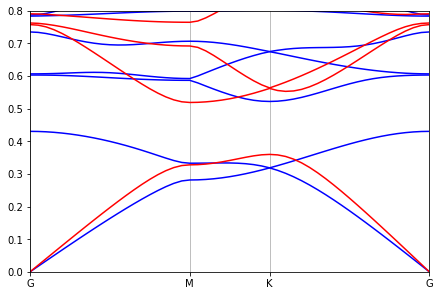

In [3]:
path = layer.lattice.bz_path(['G', 'M', 'K', 'G'], [20, 10, 20])

# Now we can run the PWE for both polarizations
pwe.run(kpoints=path.kpoints, pol='te')
freqs_te = pwe.freqs
pwe.run(kpoints=path.kpoints, pol='tm')
freqs_tm = pwe.freqs

# And plot the results!
fig, ax = plt.subplots(1, constrained_layout=True)
plt.plot(freqs_tm, 'b')
plt.plot(freqs_te, 'r')
ax.set_ylim([0, 0.8])
ax.set_xlim([0, pwe.freqs.shape[0]-1])
plt.xticks(path.pt_inds, path.pt_labels)
ax.xaxis.grid('True')
plt.show()

## Optimize the band gap with a supercell and autograd

In [4]:
import autograd.numpy as npa
from autograd import grad
core.set_backend('autograd')

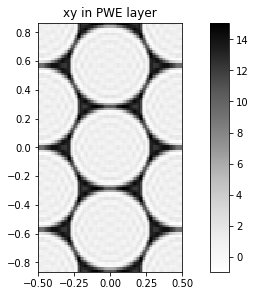

In [5]:
def pwe_3hole(rs, gmax=10):
    # Make a PWE simulation with 3 holes in the elementary cell
    # Initialize a lattice
    lattice = core.Lattice('hexagonal')
    # Initialize a layer
    layer = core.Layer(lattice, eps_b = 13)
    a_sc = np.sqrt(3)
    # Make a supercell 
    layer.add_shape('circle', {'x': 0, 'y': 0, 'r': rs[0]/a_sc, 'eps': 1})
    layer.add_shape('circle', {'x': np.sqrt(3)/2/a_sc, 'y': 0.5/a_sc, 'r': rs[1]/a_sc, 'eps': 1})
    layer.add_shape('circle', {'x': np.sqrt(3)/2/a_sc, 'y': -0.5/a_sc, 'r': rs[2]/a_sc, 'eps': 1})
    
    return PlaneWaveExp(layer, gmax=gmax)

# Initialize the PWE that should match the simulation above
pwe = pwe_3hole(0.48*npa.ones(3))
pwe.plot_overview_ft()

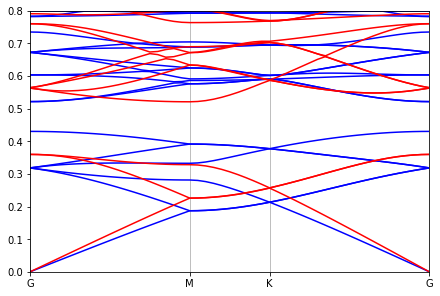

In [6]:
# Let's check that we get the same band gap despite the folded bands

path = layer.lattice.bz_path(['G', 'M', 'K', 'G'], [20, 10, 20])

# Now we can run the PWE for both polarizations
pwe.run(kpoints=path.kpoints, pol='te')
freqs_te = pwe.freqs
pwe.run(kpoints=path.kpoints, pol='tm')
freqs_tm = pwe.freqs

# And plot the results!
fig, ax = plt.subplots(1, constrained_layout=True)
plt.plot(freqs_tm/np.sqrt(3), 'b')
plt.plot(freqs_te/np.sqrt(3), 'r')
ax.set_ylim([0, 0.8])
ax.set_xlim([0, pwe.freqs.shape[0]-1])
plt.xticks(path.pt_inds, path.pt_labels)
ax.xaxis.grid('True')
plt.show()

In [8]:
# Function to return the band-gap size around a given center frequency
def bg_size(freqs_te, freqs_tm, freq_cent = 0.48):
    freqs_all = npa.hstack((freqs_te.flatten(), freqs_tm.flatten()))
    freq_min = npa.amax(npa.where(freqs_all < freq_cent, freqs_all, 0))
    freq_max = npa.amin(npa.where(freqs_all > freq_cent, freqs_all, 1e6))
    return freq_max - freq_min

print('Band gap size:', bg_size(freqs_te/np.sqrt(3), freqs_tm/np.sqrt(3))) # the sqrt(3) is because of the different lattice constant

Band gap size: 0.09076100169554063


In [9]:
# Now make the radii of the 3 holes free parameters

def of_bg(rs):
    # Initialize the PWE 
    pwe = pwe_3hole(rs)

    # Run the PWE for both polarizations
    pwe.run(kpoints=path.kpoints, pol='te')
    freqs_te = pwe.freqs/np.sqrt(3)
    pwe.run(kpoints=path.kpoints, pol='tm')
    freqs_tm = pwe.freqs/np.sqrt(3)
    
    # And return the band gap size as objective function
    # We sample several different center frequencies and take the largest bandgap found
    cfs = npa.arange(0.4, 0.6, 0.05)
    bgs = []
    for cf in cfs:
        bg = bg_size(freqs_te, freqs_tm, freq_cent=cf)
        bgs.append(bg)

    return npa.amax(npa.array(bgs))

In [12]:
# Let's first test the gradient
from core.utils import grad_num
grad_test = grad(of_bg)

print('Autograd gradient:  ', grad_test(0.48*npa.ones(3)))
print('Numerical gradient: ', grad_num(of_bg, 0.48*npa.ones(3)))

Autograd gradient:   [-0.37437648 -0.37437648 -0.37437648]
Numerical gradient:  [-0.37437702 -0.37437706 -0.37437704]


In [13]:
from core.optimizers import adam_optimize

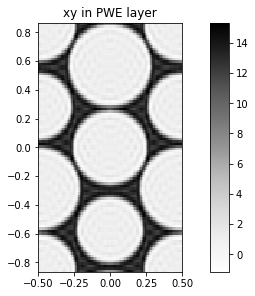

In [17]:
# Pick some starting point and show what the supercell is about
r_start = npa.array([0.45, 0.4, 0.5])
pwe = pwe_3hole(r_start)
pwe.plot_overview_ft()

In [24]:
# Run the optimization
(r_opt, ofs) = adam_optimize(of_bg, r_start, grad_test, step_size = 5e-4, Nsteps = 100, 
                             options = {'direction': 'max', 'disp': ['of', 'params']})

At iteration 0 :
Objective value is:   0.035416385643575965
Parameters are:       [ 0.4500  0.4000  0.5000]
At iteration 1 :
Objective value is:   0.03621979632227651
Parameters are:       [ 0.4505  0.4005  0.5005]
At iteration 2 :
Objective value is:   0.03702972788017156
Parameters are:       [ 0.4510  0.4010  0.5010]
At iteration 3 :
Objective value is:   0.03784611538383398
Parameters are:       [ 0.4515  0.4015  0.5015]
At iteration 4 :
Objective value is:   0.038668846801077184
Parameters are:       [ 0.4520  0.4020  0.5020]
At iteration 5 :
Objective value is:   0.03949775261630578
Parameters are:       [ 0.4525  0.4025  0.5025]
At iteration 6 :
Objective value is:   0.04033259337149775
Parameters are:       [ 0.4530  0.4030  0.5030]
At iteration 7 :
Objective value is:   0.04117304475905392
Parameters are:       [ 0.4535  0.4035  0.5035]
At iteration 8 :
Objective value is:   0.04201867987476354
Parameters are:       [ 0.4540  0.4040  0.5040]
At iteration 9 :
Objective value is

At iteration 76 :
Objective value is:   0.07644925788093443
Parameters are:       [ 0.4722  0.4369  0.5246]
At iteration 77 :
Objective value is:   0.07685050440216795
Parameters are:       [ 0.4724  0.4374  0.5247]
At iteration 78 :
Objective value is:   0.07725895974103103
Parameters are:       [ 0.4726  0.4379  0.5249]
At iteration 79 :
Objective value is:   0.07734951886303354
Parameters are:       [ 0.4728  0.4384  0.5251]
At iteration 80 :
Objective value is:   0.07786934597951556
Parameters are:       [ 0.4727  0.4389  0.5250]
At iteration 81 :
Objective value is:   0.07808470249019511
Parameters are:       [ 0.4726  0.4394  0.5248]
At iteration 82 :
Objective value is:   0.07826056161647432
Parameters are:       [ 0.4724  0.4399  0.5246]
At iteration 83 :
Objective value is:   0.07846267994943301
Parameters are:       [ 0.4723  0.4404  0.5245]
At iteration 84 :
Objective value is:   0.07868907546450654
Parameters are:       [ 0.4722  0.4410  0.5244]
At iteration 85 :
Objective 

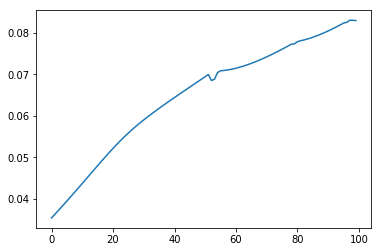

In [26]:
import matplotlib.pyplot as plt
plt.plot(ofs)
plt.show()

## Conclusion: 
- the starting structure is actually already really good (bg = 0.0907).
- the optimization here is approaching an unphysical structure cause the way things are defined right now holes shouldn't overlap...

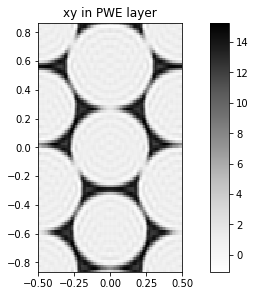

In [27]:
pwe = pwe_3hole(r_opt)
pwe.plot_overview_ft()